In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset 

The following example is adapted from \[1\].  We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors in \[1\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data \[2\] and investigate this relationship.  We will be focusing on three features from the dataset:
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `cont_africa`: whether the given nation is in Africa
  - `rgdppc_2000`: Real GDP per capita for the year 2000
  
We will take the logarithm for the response variable GDP as it tends to vary exponentially.

In [11]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df["african_rugged"] = data["cont_africa"] * data["rugged"]
df = df[["cont_africa", "rugged", "african_rugged", "rgdppc_2000"]]

# Divide the data into poredictors and response and store the data in numpy arrays
data = np.array(df)
x_data = data[:, :-1]
y_data = data[:, -1]

In [12]:
# Display first 10 entries 
display(df[0:10])

,cont_africa,rugged,african_rugged,rgdppc_2000
2,1,0.858,0.858,7.492609
4,0,3.427,0.000,8.216929
7,0,0.769,0.000,9.933263
8,0,0.775,0.000,9.407032
9,0,2.688,0.000,7.792343
11,0,0.006,0.000,9.212541
12,0,0.143,0.000,10.143191
13,0,3.513,0.000,10.274632
14,0,1.672,0.000,7.852028
15,1,1.780,1.780,6.432380


# The model

Following the approach from Day 1 we will model the data using a Bayesian linear regression model:
<img src="Bayesian_linear_regression.png" style="width: 300px;"/>
The quantitative part of the model is specified as: 
- Number of data dim: $M$
- Number of data inst: $N$
- $Y_{i}|\{{\bf w}, {\bf x}_i, \theta \} \sim \mathcal{N}({\bf w}^T{\bf x}_i, 1/\theta)$    
- ${\bf W} \sim {\mathcal N}({\bf 0}, \gamma_w^{-1}{\bf I}_{M\times M})$
- $b\sim {\mathcal N}(0,\gamma_b^{-1})$

## Helper-routine: Calculate ELBO

In [13]:
def calculate_ELBO(x_data, y_data, gamma_w, gamma_b, theta, q_w_mean, q_w_prec, q_b_mean, q_b_prec):
    """
    Helper routine: Calculate ELBO. Data is the sampled x and y values, gamma is the prior precision over the 
    weights and theta is the prior precision associated with y. Everything prefixed a 'q' relates to the 
    variational posterior.
    
    Note: This function obviously only works for this particular model and is not a general solution.

    :param x_data: The predictors
    :param y_data: The response variable
    :param gamma_w: prior precision for the weights
    :param gamma_b: prior precision for the intercept
    :param theta: prior precision for y
    :param q_w_mean: VB posterior mean for the distribution of the weights w 
    :param q_w_prec: VB posterior precision for the distribution of the weights w 
    :param q_b_mean: VB posterior mean for the intercept b
    :param q_b_prec: VB posterior precision for the intercept b
    :return: the ELBO
    """
    
    # We calculate the ELBO as E_q log p(y,x,w,b) - E_q log q(w,b), where
    # log p(y,x,w) = sum_i log p(y|x,w,b) + log p(w) + log p(b)
    # log q(w,b) = log q(w) + log q(b)

    M = x_data.shape[1]

    # E_q log p(w)
    E_log_p = -0.5 * M * np.log(2 * np.pi) + 0.5 * M * gamma_w - 0.5 * gamma_w * np.sum(np.diagonal(np.linalg.inv(q_w_prec))
                                                                                    + (q_w_mean*q_w_mean).flatten())
    # E_q log p(b)
    E_log_p += -0.5 * np.log(2 * np.pi) + 0.5 * np.log(gamma_b) - 0.5 * gamma_b * (1/q_b_prec + q_b_mean**2)

    # sum_i E_q log p(y|x,w,b)
    E_w_w = np.linalg.inv(q_w_prec) + q_w_mean @ q_w_mean.transpose()
    E_b_b = 1/q_b_prec + q_b_mean**2
    for i in range(x_data.shape[0]):
        E_x_ww_x = np.matmul(x_data[i, :].transpose(), np.matmul(E_w_w, x_data[i, :]))
        E_log_p += -0.5 * np.log(2 * np.pi) + 0.5 * np.log(theta) \
                   - 0.5 * theta * (y_data[i]**2 + E_x_ww_x + E_b_b
                                    + 2 * q_b_mean * np.matmul(q_w_mean.transpose(), x_data[i, :])
                                    - 2 * y_data[i] * np.matmul(q_w_mean.transpose(), x_data[i,:])
                                    - 2 * y_data[i] * q_b_mean)

    # Entropy of q_b
    ent = 0.5 * np.log(1 * np.pi * np.exp(1) / q_b_prec)
    ent += 0.5 * np.log(np.linalg.det(2 * np.pi * np.exp(1) * np.linalg.inv(q_w_prec)))

    return E_log_p - ent

# Full mean field
First we consider a full mean filed approach, where the variational approximation factorizes as
$$
q({\bf w}, b) = q(b)\prod _{i=1}^Mq(w_i)
$$

In [14]:
# The variational updating rule for weight component 'comp'
def update_w_comp(x_data, y_data, gamma_w, theta, q_w_mean, q_w_prec, q_b_mean, comp):

    # Lenght of weight vector
    M = x_data.shape[1]
    # The precision (a scalar)
    Q = gamma_w
    # The mean (a scalar)
    mu = 0.0
    for i in range(x_data.shape[0]):
        Q += theta * x_data[i, comp]**2
        mu += (y_data[i] - q_b_mean - (np.sum(x_data[i, :] @ q_w_mean) - x_data[i, comp]*q_w_mean[comp])) \
                * x_data[i, comp]
    mu = theta * 1/Q * mu

    # Update the appropriate entries in the mean vector and precision matrix
    q_w_prec[comp, comp] = Q
    q_w_mean[comp] = mu.item()

    return q_w_prec, q_w_mean

# The variational updating rule for the intercept
def update_b(x_data, y_data, gamma_b, theta, q_w_mean):

    # The precision (a scalar)
    tau = (gamma_b + theta * x_data.shape[0])
    # The mean (a scalar)
    mu = 0
    for i in range(x_data.shape[0]):
        mu += (y_data[i] - q_w_mean.transpose() @ x_data[i, :])
    mu = 1/tau * theta * mu

    return tau, mu

## Do the VB (full mean field)


   VB iterations:
Iteration  0. ELBO: -1444.5425131
Iteration  1. ELBO:  -862.3793596
Iteration  2. ELBO:  -606.1750951
Iteration  3. ELBO:  -464.3990899
Iteration  4. ELBO:  -383.9226147
Iteration  5. ELBO:  -337.5638038
Iteration  6. ELBO:  -310.6312475
Iteration  7. ELBO:  -294.9095301
Iteration  8. ELBO:  -285.7073539
Iteration  9. ELBO:  -280.3130187
Iteration 10. ELBO:  -277.1481572
Iteration 11. ELBO:  -275.2904416
Iteration 12. ELBO:  -274.1997031
Iteration 13. ELBO:  -273.5591903
Iteration 14. ELBO:  -273.1830309
Iteration 15. ELBO:  -272.9621099
Iteration 16. ELBO:  -272.8323581
Iteration 17. ELBO:  -272.7561507
Iteration 18. ELBO:  -272.7113914
Iteration 19. ELBO:  -272.6851025
Iteration 20. ELBO:  -272.6696619
Iteration 21. ELBO:  -272.6605930
Iteration 22. ELBO:  -272.6552665
Iteration 23. ELBO:  -272.6521380
Iteration 24. ELBO:  -272.6503005
Iteration 25. ELBO:  -272.6492213
Iteration 26. ELBO:  -272.6485874
Iteration 27. ELBO:  -272.6482151
Iteration 28. ELBO:  -272.647

Text(0, 0.5, 'ELBO')

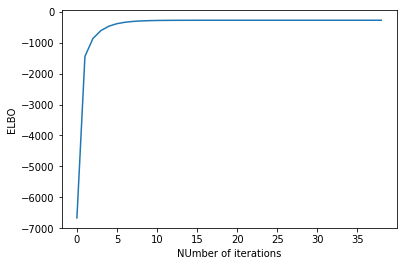

In [15]:
# Initialize the variational distributions
M = x_data.shape[1]
gamma_w = 1
gamma_b = 1
theta = 1
q_w_mean = np.random.normal(0, 1, (3, 1))
q_w_prec = np.diag((1, 1, 1))
q_b_mean = np.random.normal(0, 1)
q_b_prec = 1
elbos = []

# Calculate ELBO
this_lb = calculate_ELBO(x_data, y_data, gamma_w, gamma_b, theta, q_w_mean, q_w_prec, q_b_mean, q_b_prec)
elbos.append(this_lb)
previous_lb = -np.inf
# Start iterating
print("\n" + 100 * "=" + "\n   VB iterations:\n" + 100 * "=")
for iteration in range(100):

    # Update the variational distributions
    for i in range(M):
        q_w_prec, q_w_mean = update_w_comp(x_data, y_data, gamma_w, theta, q_w_mean, q_w_prec, q_b_mean, i)
    q_b_prec, q_b_mean = update_b(x_data, y_data, gamma_b, theta, q_w_mean)

    this_lb = calculate_ELBO(x_data, y_data, gamma_w, gamma_b, theta, q_w_mean, q_w_prec, q_b_mean, q_b_prec)
    elbos.append(this_lb)
    print(f"Iteration {iteration:2d}. ELBO: {this_lb.item():13.7f}")
    if this_lb < previous_lb:
        raise ValueError("ELBO is decreasing. Something is wrong! Goodbye...")
    
    if iteration > 0 and np.abs((this_lb - previous_lb) / previous_lb) < 1E-8:
        # Very little improvement. We are done.
        break
    
    # If we didn't break we need to run again. Update the value for "previous"
    previous_lb = this_lb
print("\n" + 100 * "=" + "\n")

# Store the results
w_mean_mf = q_w_mean
w_prec_mf = q_w_prec
b_mean_mf = q_b_mean
b_prec_mf = q_b_prec

plt.plot(range(len(elbos)), elbos)
plt.xlabel('NUmber of iterations')
plt.ylabel('ELBO')

## Model evaluation

To get a sense of the robustness of the model we draw samples from the posterior variational distributions over the weights and intercept; each sample correspond to a regression line

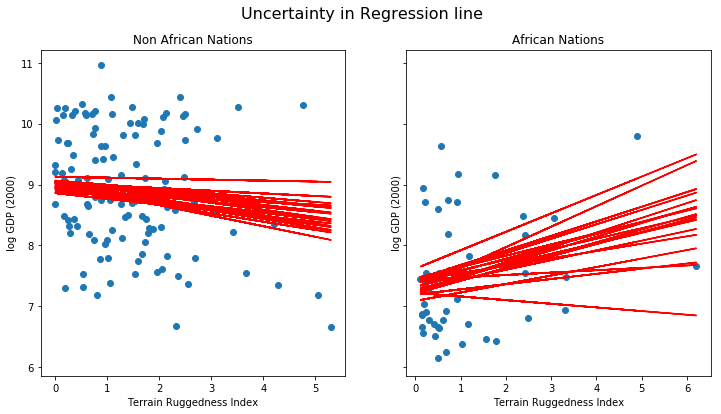

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Uncertainty in Regression line ", fontsize=16)
num_samples = 20

ax[0].scatter(x_data[x_data[:,0]==0,1], y_data[x_data[:,0]==0])
for _ in range(num_samples):
    b_sample = np.random.normal(loc=q_b_mean, scale=1/np.sqrt(q_b_prec))
    w_sample = np.random.multivariate_normal(mean=q_w_mean.flatten(), cov=np.linalg.inv(q_w_prec))
    ax[0].plot(x_data[x_data[:,0]==0,1], (x_data[x_data[:,0]==0,:] @ w_sample)+b_sample, 'r-')
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")

ax[1].scatter(x_data[x_data[:,0]==1,1], y_data[x_data[:,0]==1])
for _ in range(num_samples):
    b_sample = np.random.normal(loc=q_b_mean, scale=1/np.sqrt(q_b_prec))
    w_sample = np.random.multivariate_normal(mean=q_w_mean.flatten(), cov=np.linalg.inv(q_w_prec))
    ax[1].plot(x_data[x_data[:,0]==1,1], (x_data[x_data[:,0]==1,:] @ w_sample)+b_sample, 'r-')
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

plt.show()